In [1]:
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import networkx as nx

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
def graphToData(dir, file_id):
    locs = np.loadtxt(f"{dir}/{file_id}.locs")[:, :2] # 0<=locs<=1
    n_nodes = 100
    locs_int_2d = np.rint(locs*100).astype(int) # 0<= locs_int_2d <= 100
    locs_int = locs_int_2d[:, 0]*101 + locs_int_2d[:, 1]
    locs_int_max = 101*101
    locs_enc = np.zeros(shape=(n_nodes, locs_int_max))
    locs_enc[np.arange(n_nodes), locs_int] = 1
    adj = list()

    with open(f"{dir}/{file_id}.adj", "r") as file:
        # Read each line in the file
        n_line = 0
        for line in file:
            line = line.strip()
            neighbors = []
            if line != "None":
                neighbors = [int(id) for id in line.split()]        
            for neighbor in neighbors:
                adj.append([n_line, neighbor])
            n_line += 1
    adj_list = np.array(adj, dtype=int)

    adj_list_pt = torch.tensor(adj_list, dtype=torch.long) #shape=[num_edges, 2] <- needs to be reshaped (see pyg doc)

    #graph = np.load(file)
    #num_nodes = len(locs)
    num_edges = len(adj_list)#
    len_edges = np.sqrt(np.sum((locs[adj_list[:, 0]] - locs[adj_list[:, 1]])**2, axis=1))
    #print(len(len_edges), num_edges)
    label_ = [1, 0] if dir.split("/")[-1] == "no" else [0, 1]
    #print(label_)
    label = torch.tensor([label_], dtype=torch.float) #shape=[1, num_classes]
    #1: 
    # node_values = torch.tensor(locs, dtype=torch.float) #num_node_features = 2, shape=[num_nodes, num_node_features]
    #2:
    #node_values = torch.tensor(np.identity(100), dtype=torch.float) #num_node_features = 100
    #3:
    node_values = torch.tensor(locs_enc, dtype=float)
    
    #1: 
    # edge_values = torch.tensor(np.ones(shape=(num_edges, 1)), dtype=torch.float) #shape=[num_edges, num_edge_features]
    edge_values = torch.tensor(len_edges.reshape(-1, 1), dtype=torch.float)
    
    #positions = torch.tensor(graph["positions"], dtype=torch.float) #shape=[num_nodes, 2]
    
    return Data(x=node_values, edge_index=adj_list_pt.t().contiguous(), edge_attr=edge_values, y=label)

def loadData(root_dir):
    graphs = list()
    for subdir, dirs, files in os.walk(root_dir):
        #label= [1, 0] if subdir=="../GenData/DataCycle/cycles" else [0, 1]
        if len(dirs) > 0:
            continue
        print(subdir)
        ids = list()
        for file in tqdm(files):
            #print(subdir)
            file_id = int(file.split(".")[0])
            if file_id in ids:
                continue
            ids.append(file_id)
            graph = graphToData(subdir, file_id)
            graphs.append(graph)
            #print(file.split(".")[0])
            #print(subdir.split("/")[-1])
            #break
        print(f"Number of graphs: {len(ids)}")
        #    path = os.path.join(subdir, file)
        #    graphs.append(graphToData(path, label))
    return graphs

In [5]:
class TestLayer(torch_geometric.nn.MessagePassing):
    def __init__(self, num_node_features_in, num_node_features_out, num_edge_features_, size_nn_message_hidden, size_nn_update_hidden):
        super().__init__(aggr="add", flow="source_to_target") #source_to_target: create message to node i if (j,i) is edge
        self.num_node_features_in = num_node_features_in
        self.num_node_features_out = num_node_features_out
        self.num_edge_features = num_edge_features_
        self.nn_message = torch.nn.Sequential(
            torch.nn.Linear(in_features=2*self.num_node_features_in + self.num_edge_features, out_features=size_nn_message_hidden, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(size_nn_message_hidden, out_features=num_node_features_out, bias=True)
        )

        self.nn_update = torch.nn.Sequential(
            torch.nn.Linear(in_features=self.num_node_features_out + self.num_node_features_in, out_features=size_nn_update_hidden, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(size_nn_update_hidden, out_features=num_node_features_out, bias=True)
        )

    def forward(self, x, edge_list, edge_attr):
        out = self.propagate(edge_list, x=x, edge_attr=edge_attr) #calls message(), aggregate(), update()
        return out #shape = [number of nodes, number of node features]

    def message(self, x_i, x_j, edge_attr):
        vec_in = torch.cat((x_i, x_j, edge_attr), dim = 1) # shape = [num_edges, 2*number of node_features + number of edge_features]
        message = self.nn_message(vec_in) #shape = [num_edges, num node features]
        return message #return the message that is passed to node x_i

    def update(self, input, x):
        vec_in = torch.cat((x, input), dim = 1) #shape = [number of nodes, 2* number of node features]
        updated_input = self.nn_update(vec_in) #shape = [number of nodes, number of node features]
        return updated_input #these nodes 

In [6]:
class Test(torch.nn.Module):
    def __init__(self, num_node_features_, num_classes, num_edge_features_, num_layers, num_neurons_message, num_neurons_update):
        super().__init__()
        #expect num_node_features_ = num_classes
        num_old_node_features = num_node_features_
        num_new_node_features = num_node_features_ #+ 3
        self.first_layer = TestLayer(num_old_node_features, num_new_node_features, num_edge_features_, 
                                     num_new_node_features, num_new_node_features)
        num_old_node_features = num_new_node_features

        self.num_layers = num_layers
        self.layers = list()
        for _ in range(self.num_layers):
            num_new_node_features = num_old_node_features #+ 3
            self.layers.append(TestLayer(num_old_node_features, num_new_node_features, num_edge_features_, 
                                         num_new_node_features, num_new_node_features))
            num_old_node_features = num_new_node_features
        self.layers = torch.nn.ModuleList(self.layers)

        self.last_layer = TestLayer(num_old_node_features, num_classes, num_edge_features_, 
                                    num_new_node_features, num_new_node_features)
    
    def forward(self, batch_dat):
        x, edge_list, edge_attr, batch = batch_dat.x, batch_dat.edge_index, batch_dat.edge_attr, batch_dat.batch

        x = self.first_layer(x, edge_list, edge_attr)
        x = torch.nn.functional.relu(x)

        for i in range(self.num_layers):
            x = self.layers[i](x, edge_list, edge_attr)
            x = torch.nn.functional.relu(x)

        x = self.last_layer(x, edge_list, edge_attr) #shape=[number of nodes, number of node features=number of classe]

        logits = torch_geometric.nn.global_add_pool(x, batch) #shape [number of batches, number of classes]

        return logits

In [7]:
def train(loader, model, loss_fn, optimizer, device, save=False, file_save=""):
    total_num_dataset = len(loader.dataset)
    model.train()
    loss_save = list()
    for batch_nr, batch_dat in enumerate(loader):
        batch_dat = batch_dat.to(device)
        pred = model(batch_dat)
        loss = loss_fn(pred, batch_dat.y)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch_nr % 50 == 0:
            loss_, current = loss.item(), (batch_nr + 1)*len(batch_dat)
            print(f"loss: {loss_:>7f} [{current:>5d}/{total_num_dataset:>5d}]")
        if save:
            loss_ = loss.item()
            loss_save.append(loss_)
    if save:
        np.savetxt(fname=file_save, X=loss_save)


def test(loader, model, loss_fn, device, save=False, file_save=""):
    size = len(loader.dataset)
    num_batches = len(loader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            test_loss += loss_fn(pred, batch.y).item()
            correct += (pred.argmax(dim=1) == batch.y.argmax(dim=1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /=size
    print(f"Test Error:\n Accuracy: {(100*correct):>0.1f}%, Avg_loss: {test_loss:>8f}\n")
    if save:
        #if not os.path.exists(file_save):
        #    os.mknod(file_save)
        f = open(file_save, "a+")
        f.write(f"{test_loss},{correct}\n")
        f.close()        

In [ ]:
#load data
import random
data_list = loadData("./Data")
random.shuffle(data_list)

./Data/DataSet1/no


  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 148.72it/s]


Number of graphs: 7
./Data/DataSet1/yes


100%|██████████| 16/16 [00:00<00:00, 211.16it/s]


Number of graphs: 8
./Data/DataSet2/no


100%|██████████| 1644/1644 [00:10<00:00, 158.29it/s]


Number of graphs: 822
./Data/DataSet2/yes


 44%|████▎     | 690/1586 [01:06<1:44:07,  6.97s/it]

In [29]:
#data_list = stephen.ThreeDGraphDataset(root='3D_graphs_stephen', n_graphs_per_type=300)

train_dataloader = DataLoader(data_list[:int(0.8*len(data_list))], batch_size=8, shuffle=True)
test_dataloader = DataLoader(data_list[int(0.8*len(data_list)):], batch_size=8, shuffle=True)
print(len(train_dataloader.dataset))
print(next(iter(train_dataloader)))

1304
DataBatch(x=[800, 100], edge_index=[2, 1534], edge_attr=[1534, 1], y=[8, 2], batch=[800], ptr=[9])


In [30]:
model = Test(num_node_features_=100, num_edge_features_=1, num_classes=2, num_layers=15, num_neurons_message=5, num_neurons_update=5)
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters())

print(f"\nWithout Training\n----------------------------------------")
test(test_dataloader, model, loss_fn, device)

epochs = 30
for t in range(epochs):
    print(f"\nEpoch {t+1}\n----------------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, device)
    test(test_dataloader, model, loss_fn, device)
print("Done")


Without Training
----------------------------------------
Test Error:
 Accuracy: 48.2%, Avg_loss: 1.649793


Epoch 1
----------------------------------------
loss: 2.103812 [    8/ 1304]
loss: 0.762331 [  408/ 1304]
loss: 0.585646 [  808/ 1304]
loss: 0.514624 [ 1208/ 1304]
Test Error:
 Accuracy: 62.9%, Avg_loss: 0.622621


Epoch 2
----------------------------------------
loss: 0.582897 [    8/ 1304]
loss: 0.527034 [  408/ 1304]
loss: 0.619036 [  808/ 1304]
loss: 0.895828 [ 1208/ 1304]
Test Error:
 Accuracy: 61.7%, Avg_loss: 0.627007


Epoch 3
----------------------------------------
loss: 0.551633 [    8/ 1304]
loss: 0.708825 [  408/ 1304]
loss: 0.686373 [  808/ 1304]
loss: 0.611405 [ 1208/ 1304]
Test Error:
 Accuracy: 68.1%, Avg_loss: 0.606978


Epoch 4
----------------------------------------
loss: 1.026351 [    8/ 1304]
loss: 0.835601 [  408/ 1304]
loss: 0.618066 [  808/ 1304]
loss: 0.614554 [ 1208/ 1304]
Test Error:
 Accuracy: 60.4%, Avg_loss: 0.697242


Epoch 5
------------------

In [32]:
type_ = "no_cycles"
id_ = 50
filename = f"../GenData/DataCycle/{type_}/{id_}.npz"
graph = np.load(filename)
node_list = graph["nodes"]
adj_list = graph["edges"]
G = nx.Graph()
G.add_nodes_from(node_list)
G.add_edges_from(adj_list)
G = G.to_undirected()

label= [1, 0] if type_=="cycles" else [0, 1]
dat = graphToData(filename, label)
model.eval()
with torch.no_grad():
    dat = dat.to(device)
    pred = model(dat)
    print("predicition: ", pred)
    print("label: ", dat.y)

predicition:  tensor([[-1.3330, -0.6791]], device='cuda:0')
label:  tensor([[0., 1.]], device='cuda:0')


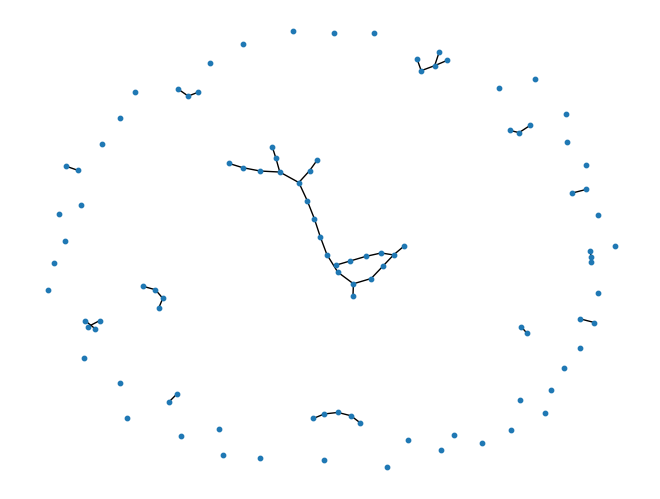

In [33]:
nx.draw(G, with_labels=False, font_weight='bold', node_size=10)